In [15]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn
from typing import Union, Sequence
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
from agronet import TriticaleModel, learning_plot, barplot, read_list, write_list

In [16]:
# Путь к данным
PATH = '' #'/content/drive/MyDrive/urozhaj/'

In [17]:
# Загрузка данных
data = pd.read_csv(PATH + 'urozhaj.csv', decimal=',')

### Непогодные признаки

In [18]:
X_gnd, Y = data.iloc[:, 10:16], data.iloc[:, 16:]
X_gnd

,pH,Gumus,P,K,vlazhnost,T_pochvy_posev
0,5.1,1.80,120,135,21,5
1,5.1,1.86,125,125,22,5
2,5.7,2.00,156,136,18,6
3,5.3,1.98,110,128,20,5
4,5.8,2.10,139,133,30,7
5,5.9,2.00,155,141,26,8
6,5.6,2.21,145,135,20,7
7,5.8,1.96,158,144,18,7
8,5.9,2.01,150,134,19,8
9,5.6,1.85,152,138,23,5


### Предобработка

In [19]:
scaler_gnd = StandardScaler()
# X_gnd_scaled = scaler_gnd.fit_transform(X_gnd) # для итогового прогона по всем
# Делим на данные на трейновую часть и валидационную
X_train, Y_train, X_val, Y_val = X_gnd.loc[:8], Y.loc[:8], X_gnd.loc[9:], Y.loc[9:]

# обезразмеривание по формулам в предыдущем файле со средним равным 0 и стандартным отклонением 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # получаем стандартное отклоение и среднее по обучающей выборке
X_val_scaled = scaler.transform(X_val)         # на валидации применяем (без fit) полученное выше, т.к. 
                                               # не можем знать параметры из новых данных
X_gnd_scaled = np.vstack((X_train_scaled, X_val_scaled)) # для итогового прогона по всем

In [20]:
# Предобработанные данные
pd.DataFrame(X_gnd_scaled, columns=X_gnd.columns, index=range(2010, 2020))

,pH,Gumus,P,K,vlazhnost,T_pochvy_posev
2010,-1.549612,-1.690015,-1.197358,0.081111,-0.147186,-1.239501
2011,-1.549612,-1.159429,-0.894655,-1.743880,0.117749,-1.239501
2012,0.396412,0.078605,0.982102,0.263610,-0.941992,-0.381385
2013,-0.900937,-0.098257,-1.802763,-1.196383,-0.412121,-1.239501
2014,0.720750,0.962915,-0.047087,-0.283887,2.237230,0.476731
2015,1.045087,0.078605,0.921562,1.176105,1.177490,1.334848
2016,0.072075,1.935656,0.316156,0.081111,-0.412121,0.476731
2017,0.720750,-0.275119,1.103183,1.723603,-0.941992,0.476731
2018,1.045087,0.167036,0.618859,-0.101388,-0.677057,1.334848
2019,0.072075,-1.247860,0.739940,0.628608,0.382684,-1.239501


### Определение оптимальных параметров

In [21]:
num_neurons = (10, 15, 20, 25, 30, 35, 40, 50)
varieties = {'konsul': '"Консул"', 'nina': '"Нина"', 'topaz': '"Топаз"', 
             'mikhas': '"Михась"', 'nemch56': '"Немчиновский 56"'}
errors_dct = {}

for label in varieties: # Пробегаем по всем культурам
    for n_neurons in num_neurons: # Пробегаем по всем количествам нейронов
        # Создаем объект модели
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                                        n_layers=2, 
                                        n_neurons=(n_neurons, 1), 
                                        random_seed=1)

        # Обучаем модель
        train_loss, valid_loss = model.train(X_train_scaled, 
                                             Y_train[f'y_{label}'], 
                                             X_val_scaled, 
                                             Y_val[f'y_{label}'],
                                             300)

        # Предсказываем урожайность на всех данных
        predictions = model.get_all_predictions(X_gnd_scaled, Y[f'y_{label}'], False, False)
        # Сохраняем ошибки, по которым далее построим графики
        errors_dct.setdefault(label, {})[n_neurons] = predictions['Relative Error']

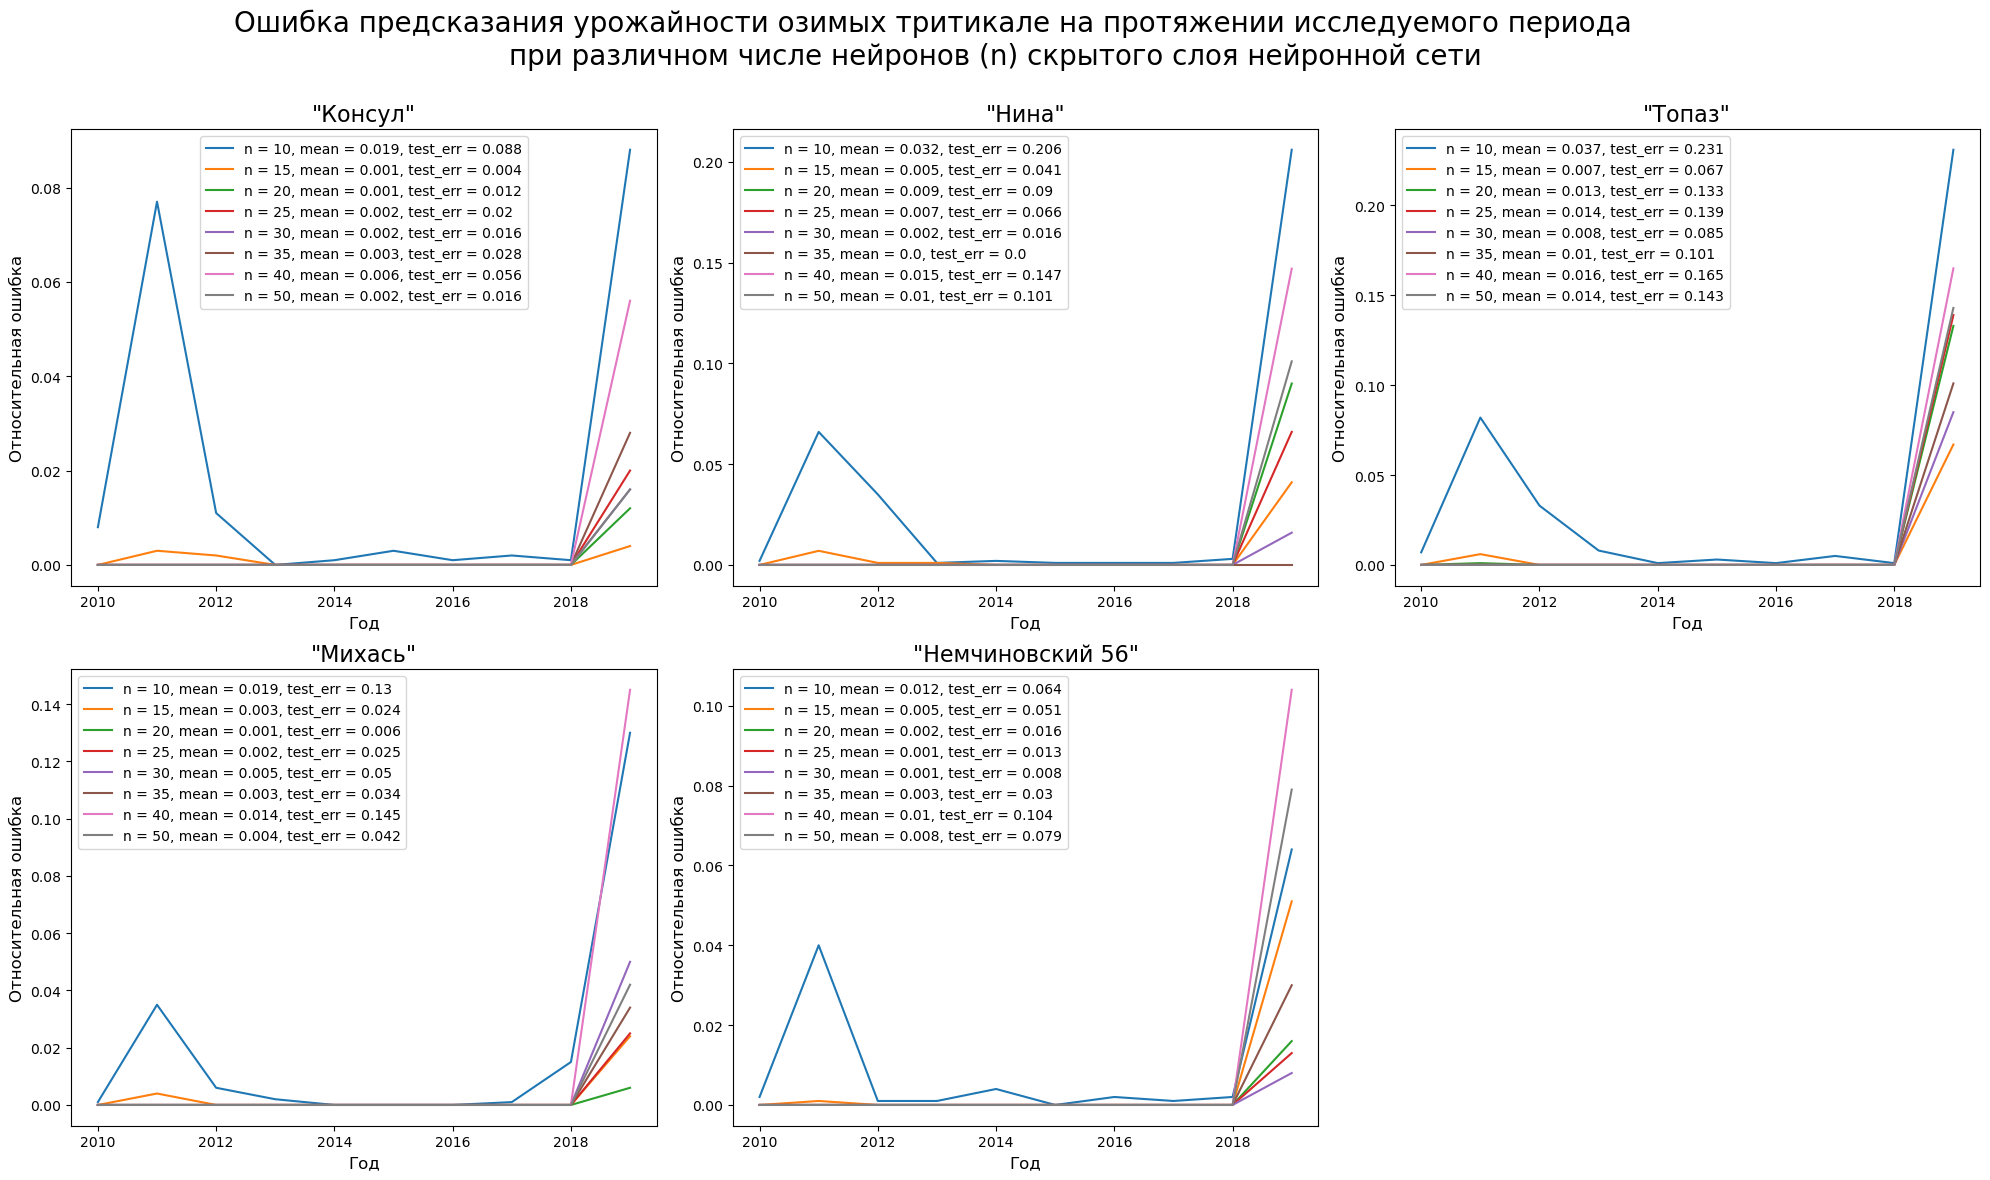

In [22]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.delaxes(axes[1][2])
fig.suptitle("Ошибка предсказания урожайности озимых тритикале на протяжении исследуемого периода\
              \nпри различном числе нейронов (n) скрытого слоя нейронной сети", fontsize=20)
test_err = {} # Сохраним ошибку на тестовом 2019-м годе для следующего графика

for ax, label in zip(axes.flatten(), varieties):
    for i, n_neurons in enumerate(num_neurons):
        values = list(errors_dct[label].values())[i]
        test_err.setdefault(label, {})[n_neurons] = values[-1]
        mean = np.mean(values).round(3)        
        legend = f'n = {n_neurons}, mean = {mean}, test_err = {values[-1]}'
        ax.plot(predictions['Year'], list(errors_dct[label].values())[i], label=legend)
        ax.set_title(varieties[label], fontsize=16)
        ax.set_ylabel('Относительная ошибка', fontsize=12)
        ax.set_xlabel('Год', fontsize=12)
        ax.grid()
        ax.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.88)

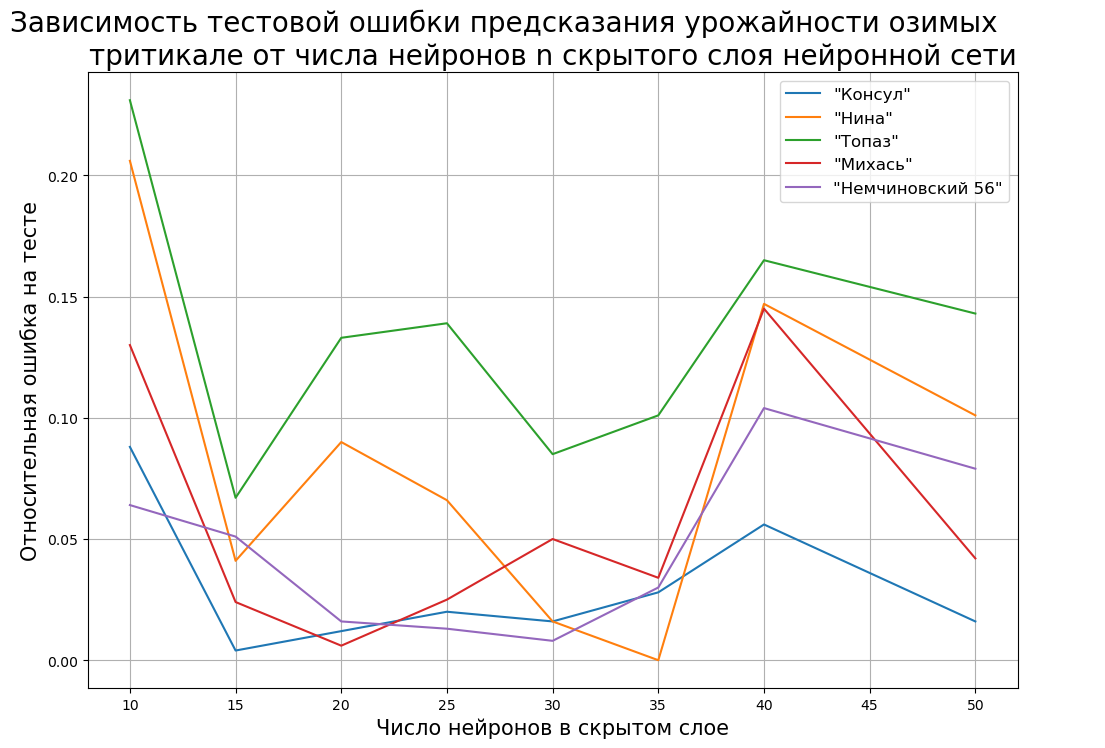

In [23]:
plt.figure(figsize=(12, 8))
plt.title("Зависимость тестовой ошибки предсказания урожайности озимых\
           \nтритикале от числа нейронов n скрытого слоя нейронной сети", fontsize=20)
for label in varieties:
    legend = varieties[label]
    plt.plot(list(test_err[label].keys()), list(test_err[label].values()), label=legend)
    plt.xlabel('Число нейронов в скрытом слое', fontsize=15)
    plt.ylabel('Относительная ошибка на тесте', fontsize=15)
    plt.grid()
    plt.legend(fontsize='large')

In [24]:
# Посмотрим при скольких нейронах в скрытом слое ошибка минимальна
for label in varieties:
    list_min = []
    for n_neurons in num_neurons:
        list_min.append(errors_dct[label][n_neurons][-1])
    print(label, num_neurons[np.argmin(list_min)], min(list_min), sep=': ')

konsul: 15: 0.004
nina: 35: 0.0
topaz: 15: 0.067
mikhas: 20: 0.006
nemch56: 30: 0.008


### Обучение моделей с полученными оптимальными значениями числа нейронов

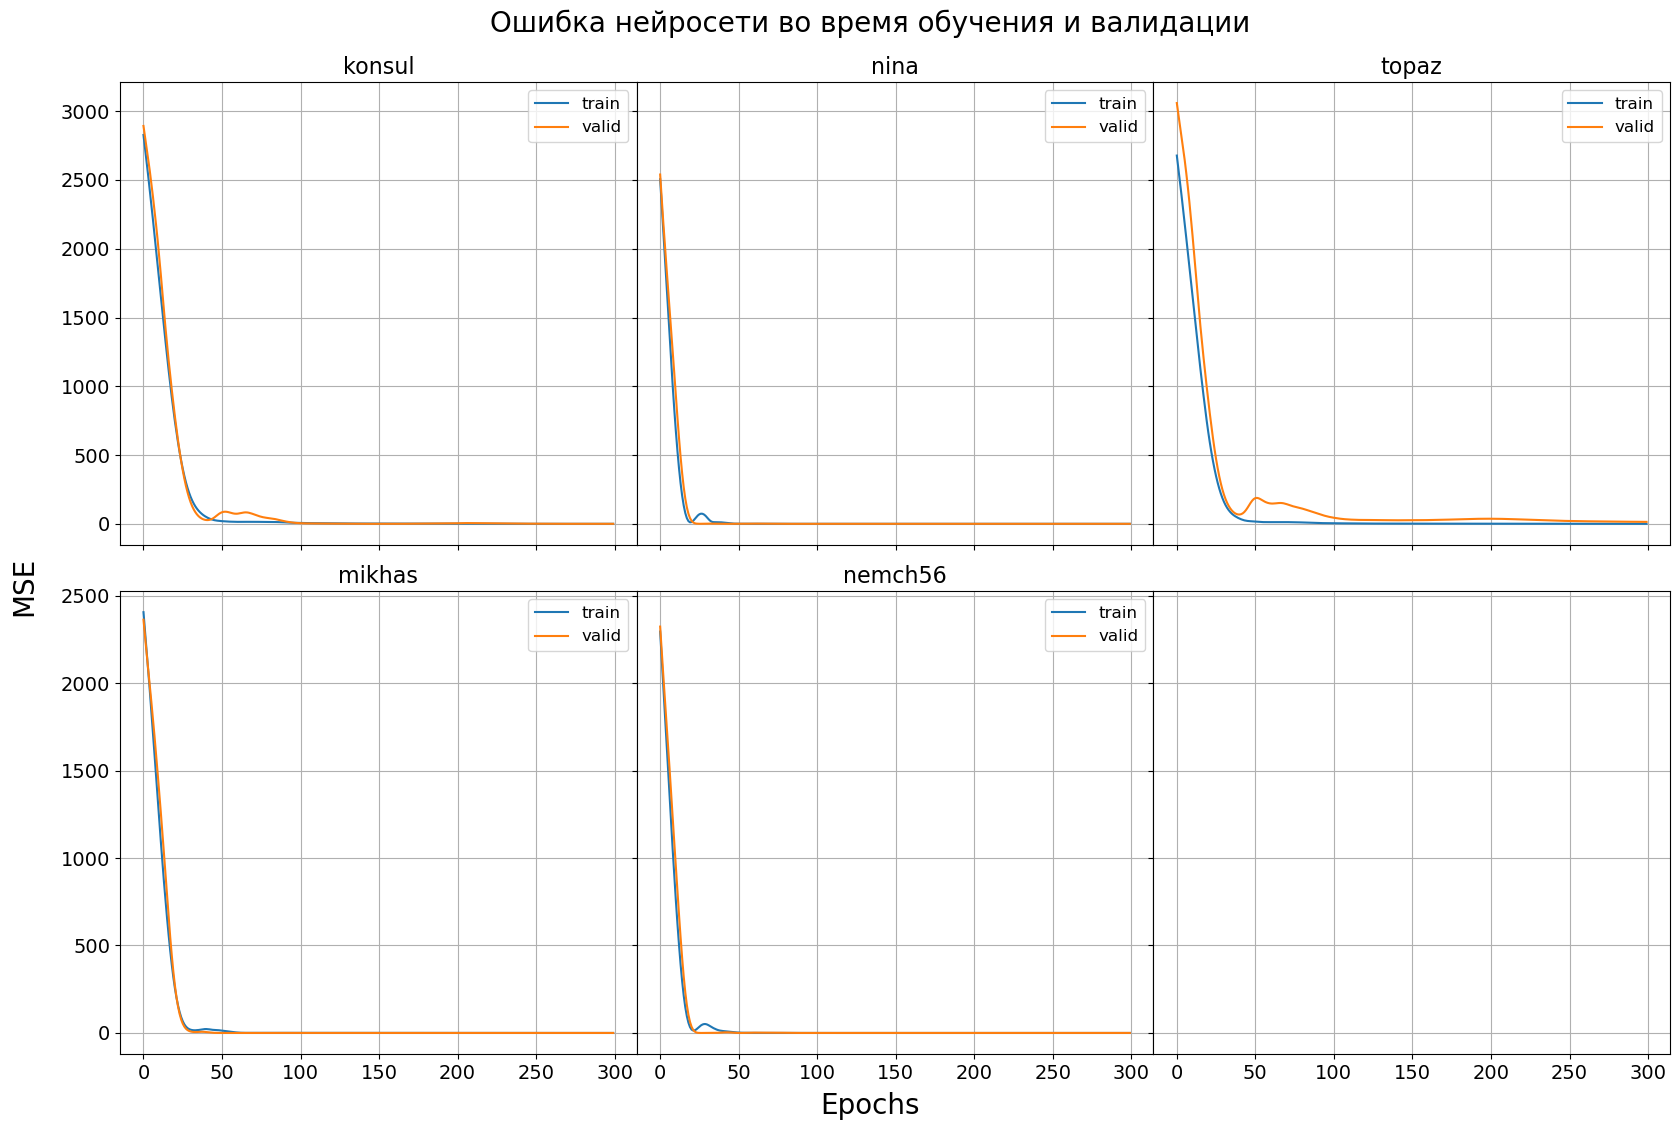

In [25]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12), sharex='col', sharey='row')
fig.suptitle('Ошибка нейросети во время обучения и валидации', fontsize=20)
# Пробегаем по всем сортам озимых
for ax, model_name in zip(axes.flatten(), varieties):
    # Создаем модель для каждого сорта
    if model_name in ['konsul', 'topaz']:
        n = 15 # число нейронов в скрытос слое
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                               n_layers=2, 
                               n_neurons=(n, 1), 
                               random_seed=1)
    elif model_name == 'nina':
        n = 35
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                               n_layers=2, 
                               n_neurons=(n, 1), 
                               random_seed=1)
    elif model_name == 'mikhas':
        n = 20
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                               n_layers=2, 
                               n_neurons=(n, 1), 
                               random_seed=1)
    else:
        n = 30
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                               n_layers=2, 
                               n_neurons=(n, 1), 
                               random_seed=1)

    # Обучаем, получаем модель и ошибки обучения
    train_loss, valid_loss = model.train(X_train_scaled, 
                                         Y_train[f'y_{model_name}'], 
                                         X_val_scaled, 
                                         Y_val[f'y_{model_name}'], 
                                         300,
                                         PATH + f'{model_name}_gnd.pt')

    # Строим графики потерь для каждого сорта
    ax.plot(train_loss, label='train')
    ax.plot(valid_loss, label='valid')
    ax.set_title(model_name, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    ax.grid()
    ax.legend(fontsize='large')

fig.text(0.5, 0.06, 'Epochs', ha='center', fontsize=20)
fig.text(0.07, 0.5, 'MSE', va='center', rotation='vertical', fontsize=20)
plt.tick_params(axis='x', labelsize=14) # Чтобы не вылетала ось ячейки без объекта (6-я)
plt.grid() # Чтобы не вылетала сетка в ячейке без объекта (6-я)
plt.subplots_adjust(top=0.92, wspace=0, hspace=0.1)

### Визуализация сравнения моделей (с и без погодных условий)

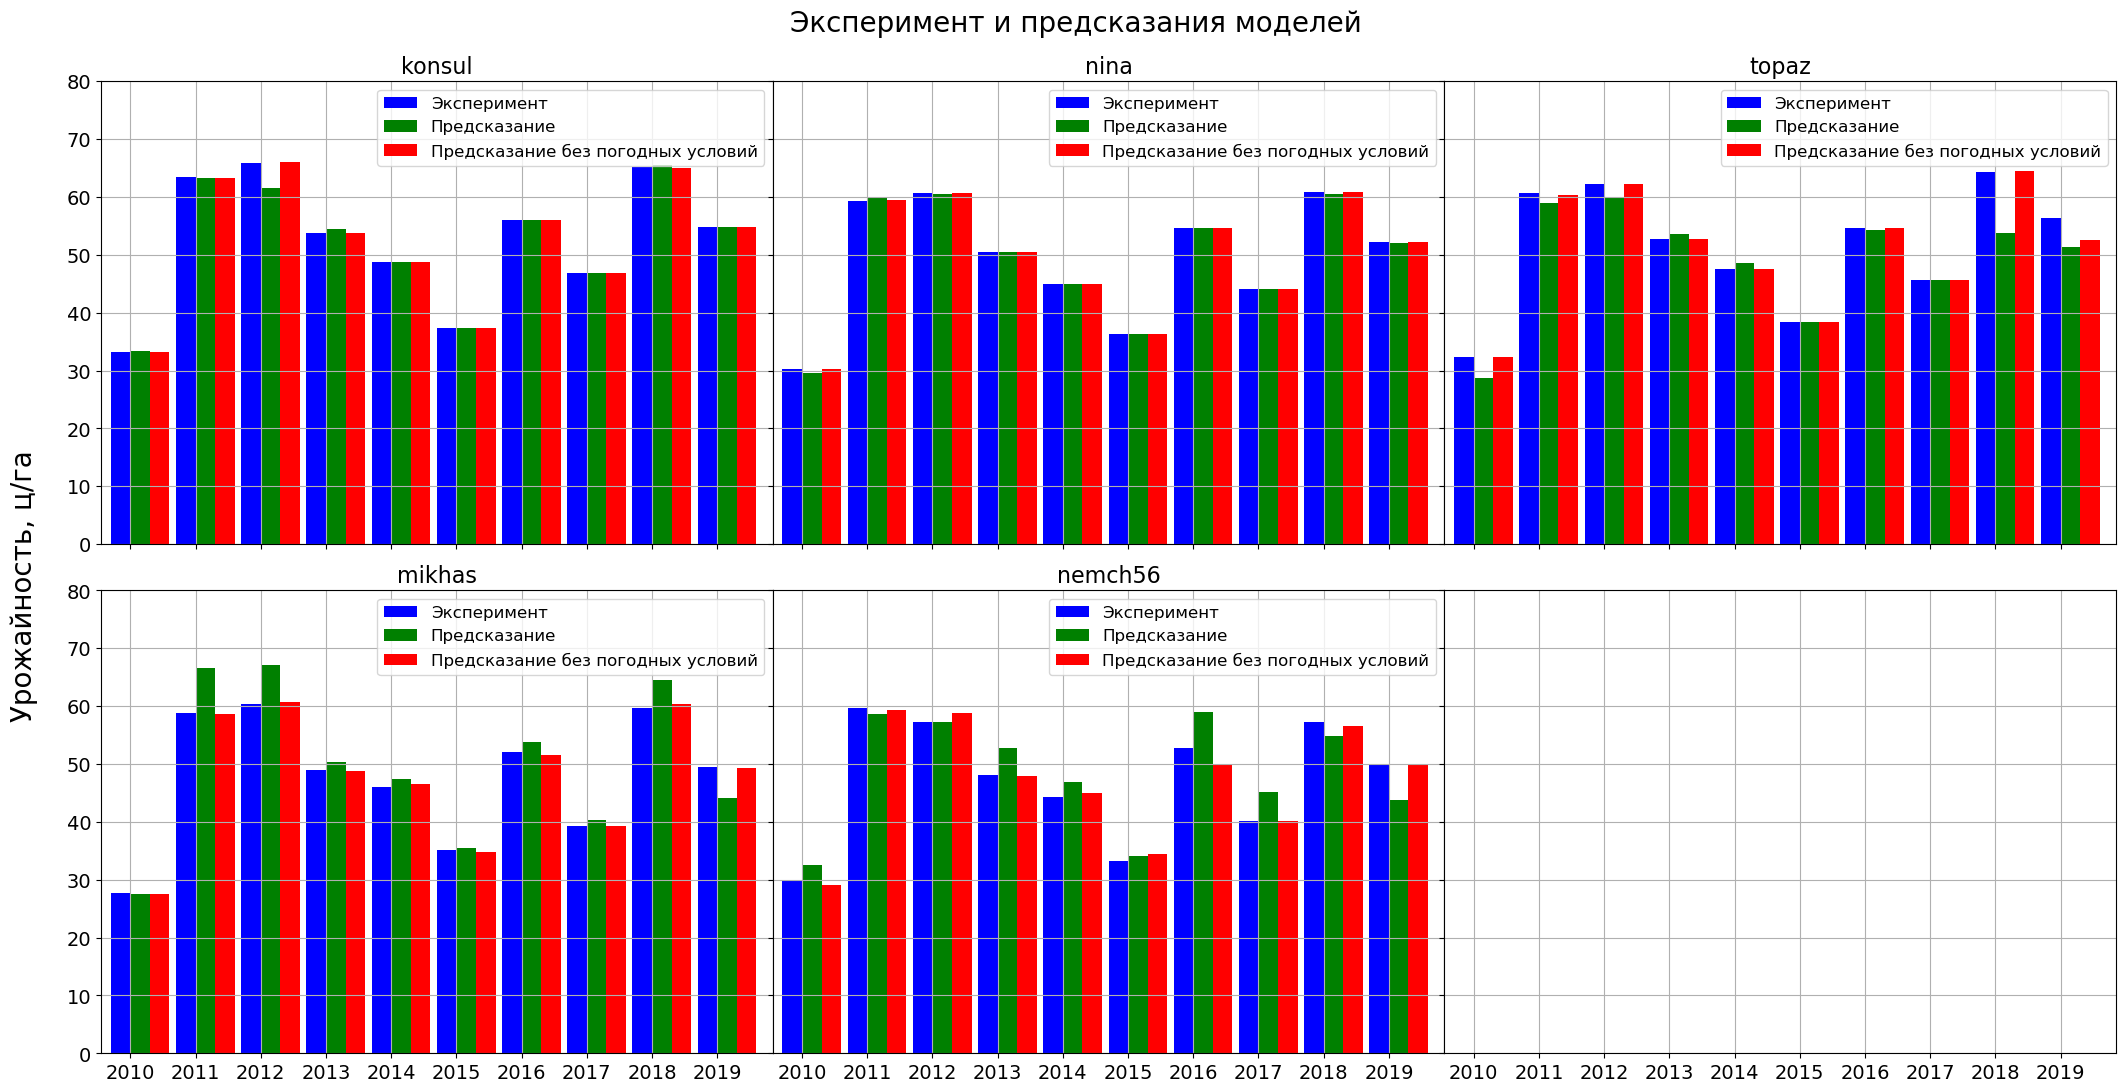

In [26]:
# Загружаем результаты предсказаний с погодой
all_preds_weather = read_list(PATH, file_name='all_preds')
# Словарь для результатов без погодных условий
total_preds_info = {}
fig, axes = plt.subplots(2, 3, figsize=(26, 12), sharex='col', sharey='row')
fig.suptitle('Эксперимент и предсказания моделей', fontsize=20)
index = np.arange(10)
bw = 0.3

for ax, model_name in zip(axes.flatten(), varieties):
    # Создаем модели
    if model_name in ['konsul', 'topaz']:
        n = 15 # число нейронов в скрытос слое
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                               n_layers=2, 
                               n_neurons=(n, 1), 
                               random_seed=1)
    elif model_name == 'nina':
        n = 35
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                               n_layers=2, 
                               n_neurons=(n, 1), 
                               random_seed=1)
    elif model_name == 'mikhas':
        n = 20
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                               n_layers=2, 
                               n_neurons=(n, 1), 
                               random_seed=1)
    else:
        n = 30
        model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                               n_layers=2, 
                               n_neurons=(n, 1), 
                               random_seed=1)
        
    # Загружаем веса лучшей модели, сохраненной после обучения, и получаем предсказания
    model.load_model(PATH + f'{model_name}_gnd.pt')
    total_preds_info[model_name] = model.get_all_predictions(X_gnd_scaled, Y[f'y_{model_name}'], False, False)
    # График
    ax.axis([-0.3, 10, 0, 80])
    ax.set_title(model_name, fontsize=16)
    ax.bar(index, Y[f'y_{model_name}'], bw, color='b')
    ax.bar(index+bw, all_preds_weather[model_name], bw, color='g')
    ax.bar(index+2*bw, total_preds_info[model_name]['Predictions'], bw, color='r')
    
    ax.set_xticks(index+bw/2, total_preds_info[model_name]['Year'])
    ax.tick_params(axis='both', labelsize=14)
    ax.grid()
    ax.legend(['Эксперимент', 'Предсказание', 'Предсказание без погодных условий'], fontsize='large')

fig.text(0.09, 0.5, 'Урожайность, ц/га', va='center', rotation='vertical', fontsize=20)
plt.tick_params(axis='x', labelsize=14) # Чтобы не вылетала ось ячейки без объекта (6-я)
plt.grid() # Чтобы не вылетала сетка в ячейке без объекта (6-я)
plt.subplots_adjust(top=0.92, wspace=0, hspace=0.1)

Развернем столбчатые диаграммы в кусочно-линейную форму

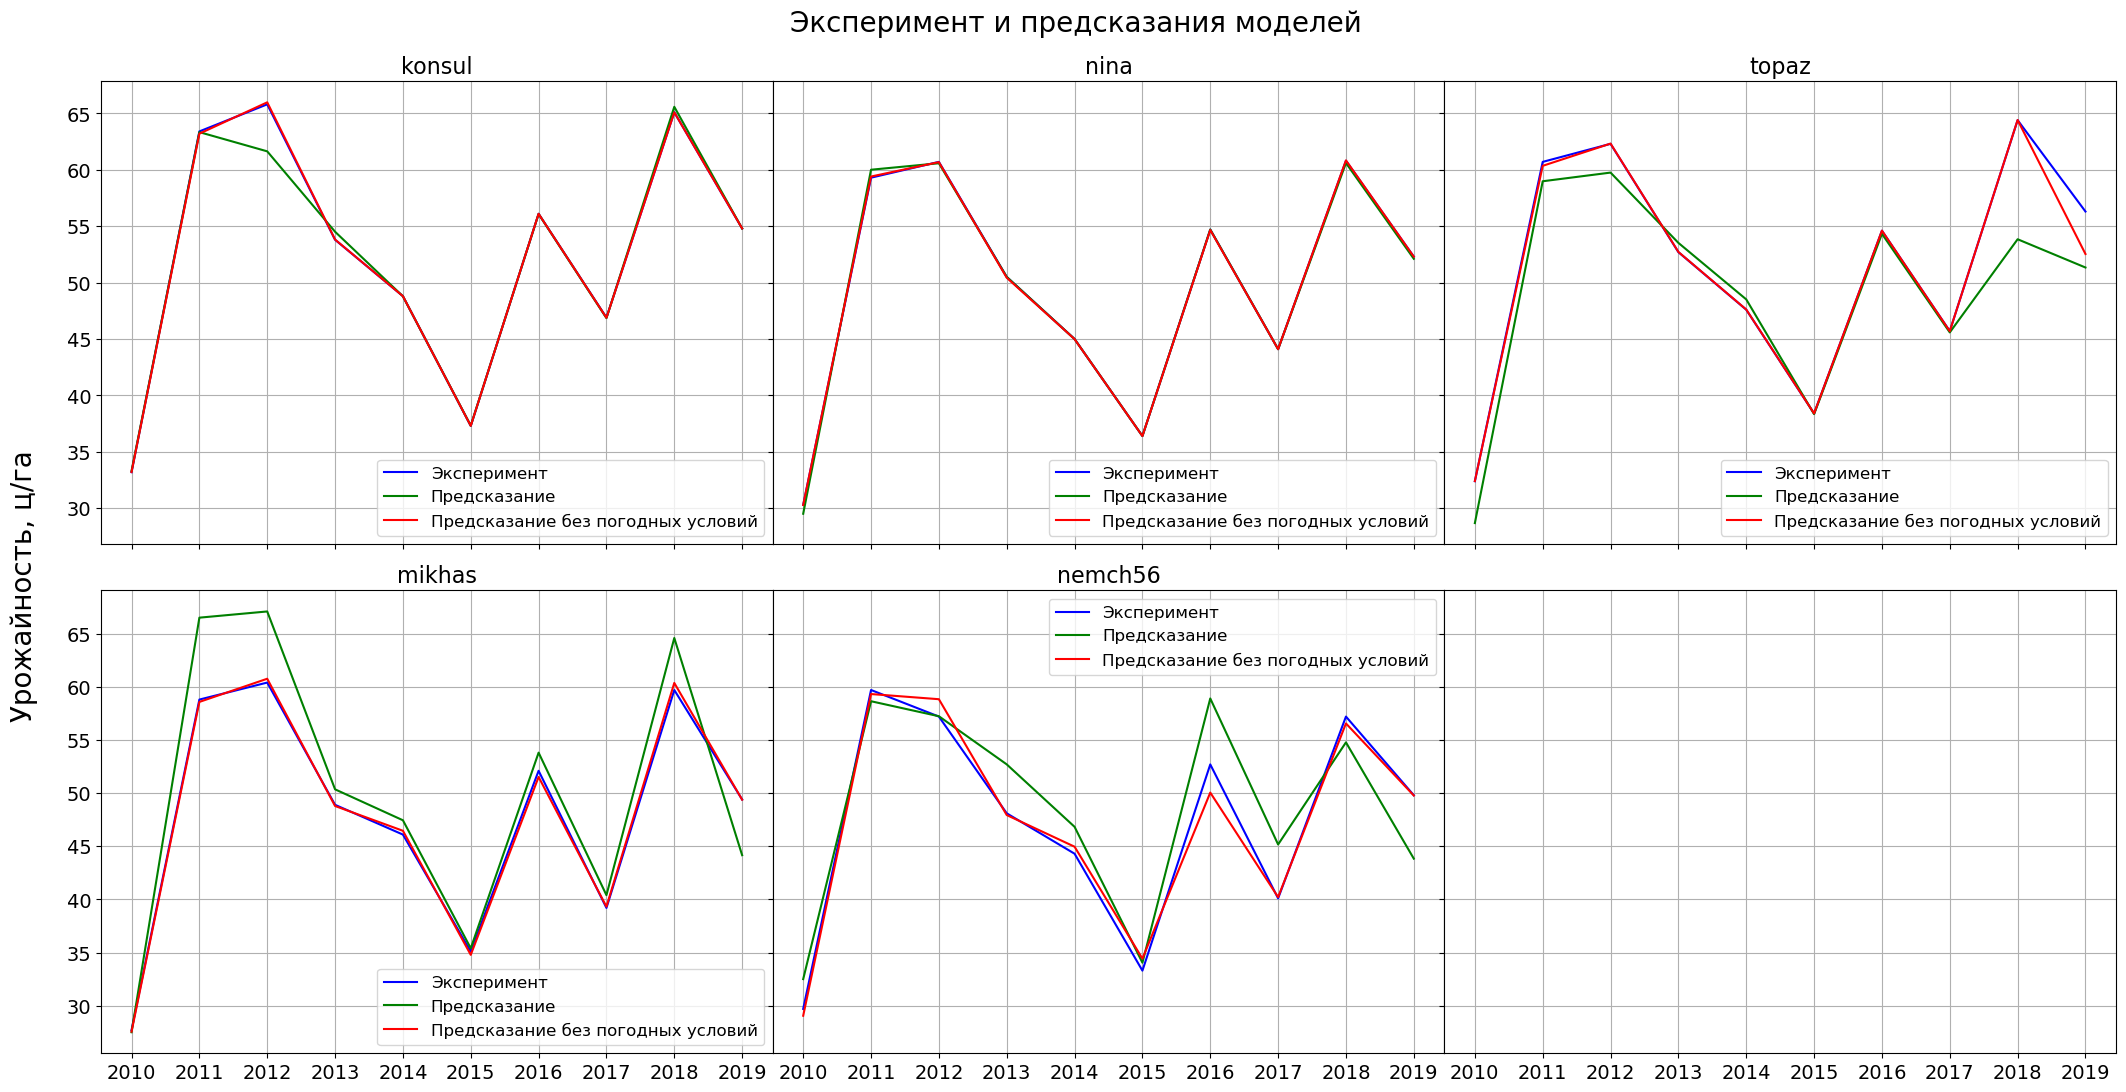

In [27]:
fig, axes = plt.subplots(2, 3, figsize=(26, 12), sharex='col', sharey='row')
fig.suptitle('Эксперимент и предсказания моделей', fontsize=20)
for ax, model_name in zip(axes.flatten(), varieties):
    #ax.axis([-0.3, 10, 0, 80])
    ax.set_title(model_name, fontsize=16)
    ax.plot(total_preds_info[model_name]['Year'], Y[f'y_{model_name}'], color='b')
    ax.plot(total_preds_info[model_name]['Year'], all_preds_weather[model_name], color='g')
    ax.plot(total_preds_info[model_name]['Year'], total_preds_info[model_name]['Predictions'], color='r')
    
    ax.set_xticks(total_preds_info[model_name]['Year'])
    ax.tick_params(axis='both', labelsize=14)
    ax.grid()
    ax.legend(['Эксперимент', 'Предсказание', 'Предсказание без погодных условий'], fontsize='large')

fig.text(0.09, 0.5, 'Урожайность, ц/га', va='center', rotation='vertical', fontsize=20)
plt.tick_params(axis='x', labelsize=14) # Чтобы не вылетала ось ячейки без объекта (6-я)
plt.grid() # Чтобы не вылетала сетка в ячейке без объекта (6-я)
plt.subplots_adjust(top=0.92, wspace=0, hspace=0.1)

Можно заметить, что удаление погодных признаков в наших данных улучшает точность прогноза

Теперь визуализируем отклонения от эксперимента в абсолютных значениях в виде таблицы

In [37]:
# Датафрейм отклонений предсказаний с погодой от эксперимента
exp_weather_preds_diff = pd.DataFrame(
                                    abs((pd.DataFrame(all_preds_weather).values - Y.values)).round(2), 
                                    index=index+2010, 
                                    columns=len(varieties) * ['w'])

# База под общий датафрейм с учетом результатов "с" и "без" погоды
exp_preds_diff = exp_weather_preds_diff.copy()

In [38]:
# Датафрейм отклонений предсказаний без погоды от эксперимента
exp_no_weather_preds_diff = pd.DataFrame(
                                pd.DataFrame(total_preds_info).loc['Absolute Error'].to_dict(), 
                                index=index+2010) \
                                .round(2) \
                                .rename(dict(zip(varieties, len(varieties) * ['w/o'])), axis=1)

In [39]:
# Прочередуем ошибки предсказаний с погодными условиями и без для каждой культуры
k = 0
for i in range(len(varieties)):
    exp_preds_diff.insert(i+1+k, 'w/o',
                          exp_no_weather_preds_diff.iloc[:, i], 
                          allow_duplicates=True)
    k += 1

In [40]:
# Введём мультииндексы в таблицу: "w" - с погодой, "w/o" -без погоды
iterables = [varieties.keys(), ["w", "w/o"]]

exp_preds_diff.columns = pd.MultiIndex.from_product(iterables)

In [41]:
exp_preds_diff

konsul        nina        topaz       mikhas       nemch56      
          w   w/o     w   w/o      w   w/o      w   w/o       w   w/o
2010   0.10  0.01  0.79  0.01   3.71  0.01   0.19  0.14    2.80  0.64
2011   0.06  0.20  0.70  0.10   1.72  0.35   7.71  0.22    1.06  0.38
2012   4.17  0.18  0.12  0.02   2.55  0.02   6.69  0.36    0.03  1.63
2013   0.71  0.02  0.01  0.07   0.82  0.02   1.46  0.11    4.60  0.16
2014   0.01  0.00  0.00  0.01   0.91  0.01   1.35  0.36    2.53  0.66
2015   0.02  0.01  0.00  0.00   0.06  0.00   0.30  0.31    0.75  1.13
2016   0.02  0.00  0.01  0.04   0.28  0.01   1.71  0.58    6.20  2.65
2017   0.05  0.01  0.00  0.00   0.11  0.01   1.20  0.12    5.07  0.11
2018   0.48  0.01  0.20  0.03  10.56  0.01   4.89  0.66    2.43  0.65
2019   0.01  0.00  0.19  0.00   4.96  3.77   5.24  0.02    5.96  0.02

In [44]:
# w - с погодой, n/w - без погоды
def highlight_min(s):
    # Делаем копию первой строки датасета, т.к. axis=1
    df = s.copy()
    # Перебираем по всем полям в строке уровня 0 (level=0) 
    for x in varieties:
        # Делаем копию подстроки - копию поля уровня 0
        col0 = df[x].copy()
        # Сравниваем значения отклонений с учётом погоды и без, помечая меньшие
        col0.loc['w/o'] = (col0.loc['w'] > col0.loc['w/o'])
        col0.loc['w'] = not col0.loc['w/o']
        col0 = col0.map({True: 'background-color: yellow;', False: ''})
        # Обновляем значения в исходнике изменённой копией
        df[x] = col0.values    
    return df

exp_preds_diff.style.apply(highlight_min, axis=1).format(precision=2)

In [48]:
### Статистический тест

Уберем фиксацию параметров `random_seed` и посмотрим на разброс ошибок

In [47]:
# Пробегаем по всем культурам
for label in varieties:
    errors = []
    # Делаем эксперимент 1000 раз
    for i in tqdm(range(1000)):
        # Создаем модели
        if model_name in ['konsul', 'topaz']:
            n = 15 # число нейронов в скрытос слое
            model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                                   n_layers=2, 
                                   n_neurons=(n, 1))
        elif model_name == 'nina':
            n = 35
            model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                                   n_layers=2, 
                                   n_neurons=(n, 1))
        elif model_name == 'mikhas':
            n = 20
            model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                                   n_layers=2, 
                                   n_neurons=(n, 1))
        else:
            n = 30
            model = TriticaleModel(n_inputs=X_train_scaled.shape[1], 
                                   n_layers=2, 
                                   n_neurons=(n, 1))
        
        model.train(X_train_scaled, Y_train[f'y_{label}'], X_val_scaled, Y_val[f'y_{label}'], 300)
        pred, loss = model.predict(X_gnd_scaled[-1], Y[f'y_{label}'][9])
        errors.append(loss ** 0.5 / Y[f'y_{label}'][9])
    write_list(errors, PATH, f'er_{label}_gnd') # Сохраняем ошибки

  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


  0%|          | 0/1000 [00:00<?, ?it/s]

Done writing list into a binary file


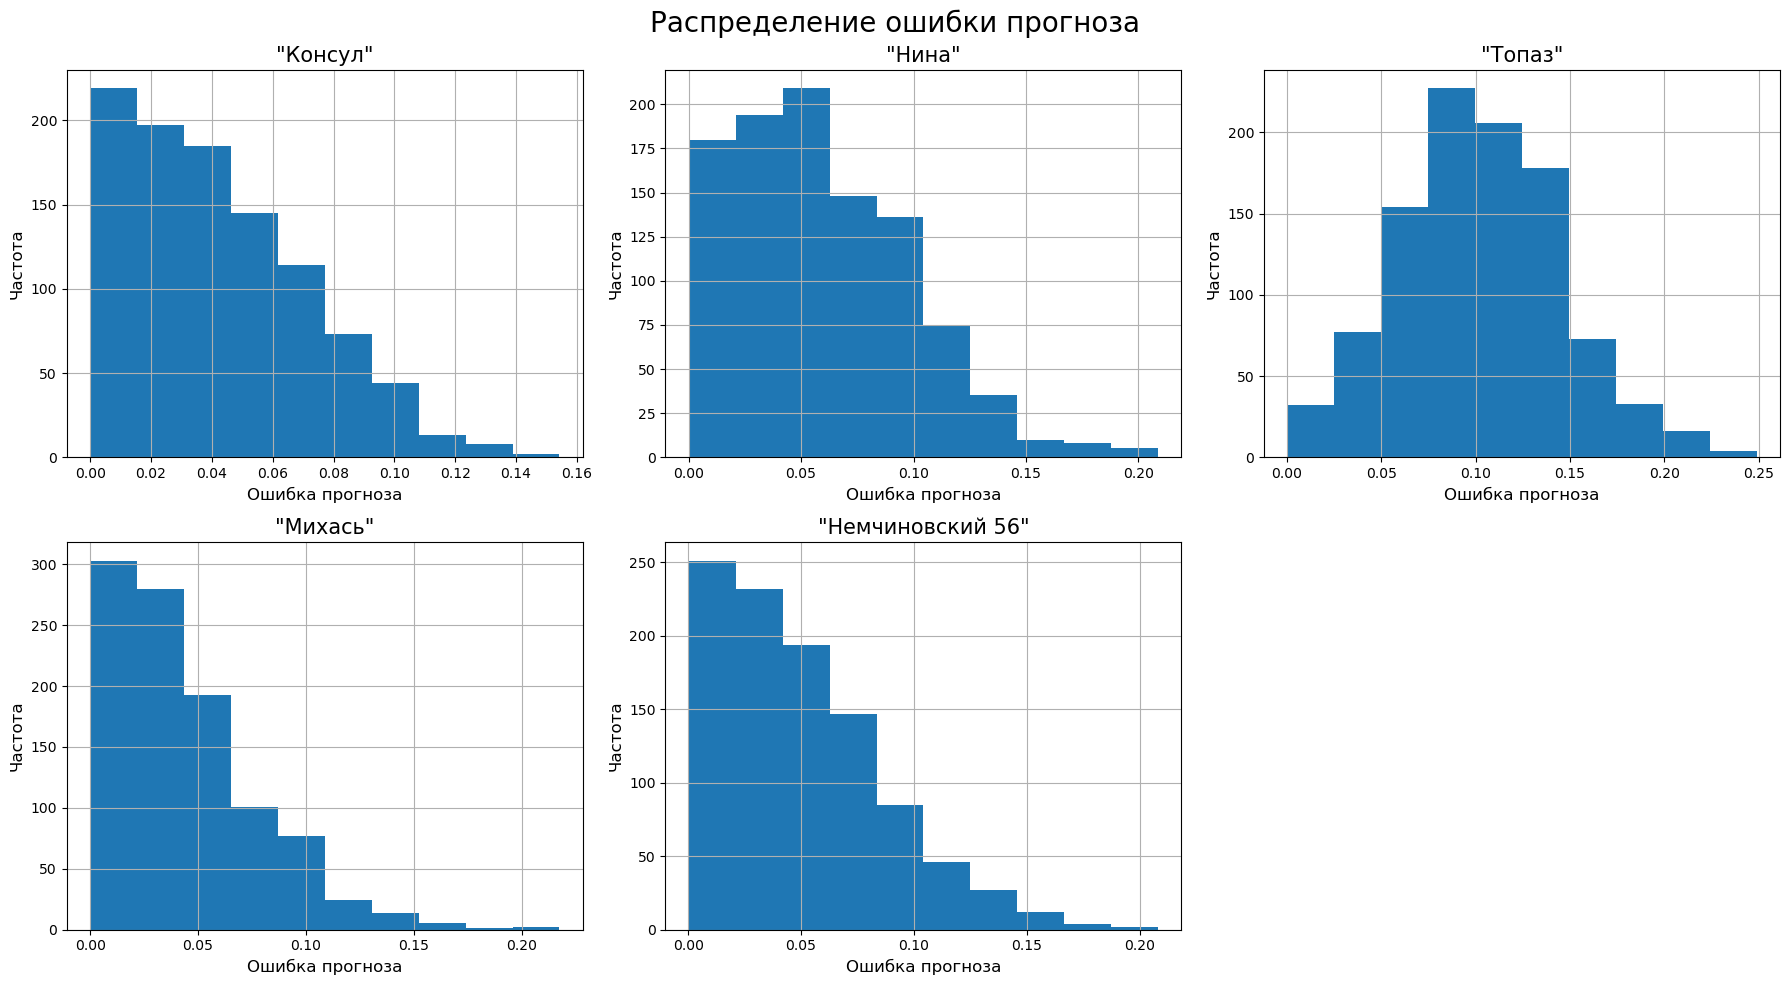

In [49]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle("Распределение ошибки прогноза", fontsize=20)
fig.delaxes(axes[1][2])
for ax, label in zip(axes.flatten(), varieties):
    errors = read_list(PATH, f'er_{label}_gnd')
    ax.hist(errors)
    ax.set_title(varieties[label], fontsize=15)
    ax.set_xlabel('Ошибка прогноза', fontsize=12)
    ax.set_ylabel('Частота', fontsize=12)
    ax.grid()
plt.tight_layout()
plt.subplots_adjust(top=0.92)

Видно, что значительно уменьшился разброс. Удаление погодных признаков позитивно сыграло на результатах предсказания

In [50]:
for label in varieties:
    errors = read_list(PATH, f'er_{label}_gnd')
    freq, val = np.histogram(errors)
    low = np.quantile(errors, 0.025).round(3)
    high = np.quantile(errors, 0.975).round(3)
    print(f"Самый часто встречаемый диапазон ошибок в культуре {varieties[label]}:")
    print((val[np.argmax(freq)].round(3), val[np.argmax(freq) + 1].round(3)))
    print(f"Доля значений: {max(freq/len(errors))}")
    print(f"С вероятностью 0.95 ошибка будет в диапазоне: {(low, high)}")
    print()

Самый часто встречаемый диапазон ошибок в культуре "Консул":
(0.0, 0.015)
Доля значений: 0.219
С вероятностью 0.95 ошибка будет в диапазоне: (0.002, 0.107)

Самый часто встречаемый диапазон ошибок в культуре "Нина":
(0.042, 0.063)
Доля значений: 0.209
С вероятностью 0.95 ошибка будет в диапазоне: (0.003, 0.145)

Самый часто встречаемый диапазон ошибок в культуре "Топаз":
(0.075, 0.1)
Доля значений: 0.227
С вероятностью 0.95 ошибка будет в диапазоне: (0.02, 0.193)

Самый часто встречаемый диапазон ошибок в культуре "Михась":
(0.0, 0.022)
Доля значений: 0.303
С вероятностью 0.95 ошибка будет в диапазоне: (0.001, 0.123)

Самый часто встречаемый диапазон ошибок в культуре "Немчиновский 56":
(0.0, 0.021)
Доля значений: 0.251
С вероятностью 0.95 ошибка будет в диапазоне: (0.002, 0.139)

